In [7]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import seaborn as sns

def analyse_nifti_distribution(data_dir, file_pattern="*.nii*"):
    """
    Analyse the distribution of min and max values across all NIfTI files in a directory.
    
    Args:
        data_dir (Path): Directory containing NIfTI files
        file_pattern (str): Pattern to match NIfTI files
    """
    data_dir = Path(data_dir)
    
    # Find all NIfTI files
    nifti_files = list(data_dir.rglob(file_pattern))
    print(f"Found {len(nifti_files)} NIfTI files in {data_dir}")
    
    if len(nifti_files) == 0:
        print("No NIfTI files found!")
        return None
    
    # Store min/max values for each file
    file_mins = []
    file_maxs = []
    file_names = []
    
    print("Processing files...")
    
    for i, nifti_path in enumerate(tqdm(nifti_files, desc="Analyzing files")):
        try:
            # Load NIfTI file
            img = nib.load(nifti_path)
            volume = img.get_fdata(dtype=np.float32)
            
            # Calculate min and max
            vol_min = np.min(volume)
            vol_max = np.max(volume)
            
            file_mins.append(vol_min)
            file_maxs.append(vol_max)
            file_names.append(nifti_path.name)
            
            # Print progress every 50 files
            if (i + 1) % 50 == 0:
                print(f"Processed {i+1}/{len(nifti_files)} files")
                
        except Exception as e:
            print(f"Error processing {nifti_path}: {e}")
            continue
    
    file_mins = np.array(file_mins)
    file_maxs = np.array(file_maxs)
    
    # Print summary statistics
    print("\n" + "="*60)
    print("DISTRIBUTION ANALYSIS SUMMARY")
    print("="*60)
    print(f"Successfully processed: {len(file_mins)} files")
    print(f"Failed to process: {len(nifti_files) - len(file_mins)} files")
    
    print(f"\nGLOBAL MIN VALUES:")
    print(f"  Overall minimum: {np.min(file_mins):.6f}")
    print(f"  Overall maximum: {np.max(file_mins):.6f}")
    print(f"  Mean of mins: {np.mean(file_mins):.6f}")
    print(f"  Std of mins: {np.std(file_mins):.6f}")
    
    print(f"\nGLOBAL MAX VALUES:")
    print(f"  Overall minimum: {np.min(file_maxs):.6f}")
    print(f"  Overall maximum: {np.max(file_maxs):.6f}")
    print(f"  Mean of maxs: {np.mean(file_maxs):.6f}")
    print(f"  Std of maxs: {np.std(file_maxs):.6f}")
    
    # Calculate percentiles
    min_percentiles = np.percentile(file_mins, [1, 5, 10, 25, 50, 75, 90, 95, 99])
    max_percentiles = np.percentile(file_maxs, [1, 5, 10, 25, 50, 75, 90, 95, 99])
    
    print(f"\nMIN VALUES PERCENTILES:")
    percentile_labels = [1, 5, 10, 25, 50, 75, 90, 95, 99]
    for p, v in zip(percentile_labels, min_percentiles):
        print(f"  {p:2d}%: {v:8.4f}")
    
    print(f"\nMAX VALUES PERCENTILES:")
    for p, v in zip(percentile_labels, max_percentiles):
        print(f"  {p:2d}%: {v:8.4f}")
    
    # Create visualizations
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram of min values
    axes[0].hist(file_mins, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_title('Distribution of Minimum Values per File')
    axes[0].set_xlabel('Minimum Value')
    axes[0].set_ylabel('Number of Files')
    axes[0].axvline(np.mean(file_mins), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(file_mins):.3f}')
    axes[0].legend()
    
    # Histogram of max values
    axes[1].hist(file_maxs, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_title('Distribution of Maximum Values per File')
    axes[1].set_xlabel('Maximum Value')
    axes[1].set_ylabel('Number of Files')
    axes[1].axvline(np.mean(file_maxs), color='red', linestyle='--', 
                       label=f'Mean: {np.mean(file_maxs):.3f}')
    axes[1].legend()
    
    
    # Additional detailed plot for outlier detection
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Zoomed histogram of min values (focus on main distribution)
    min_q1, min_q99 = np.percentile(file_mins, [1, 99])
    filtered_mins = file_mins[(file_mins >= min_q1) & (file_mins <= min_q99)]
    axes[0].hist(filtered_mins, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_title(f'Min Values Distribution (1%-99% range)\n[{min_q1:.3f}, {min_q99:.3f}]')
    axes[0].set_xlabel('Minimum Value')
    axes[0].set_ylabel('Number of Files')
    
    # Zoomed histogram of max values
    max_q1, max_q99 = np.percentile(file_maxs, [1, 99])
    filtered_maxs = file_maxs[(file_maxs >= max_q1) & (file_maxs <= max_q99)]
    axes[1].hist(filtered_maxs, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_title(f'Max Values Distribution (1%-99% range)\n[{max_q1:.3f}, {max_q99:.3f}]')
    axes[1].set_xlabel('Maximum Value')
    axes[1].set_ylabel('Number of Files')
    
    plt.tight_layout()
    plt.show()
    
    # Identify specific outliers based on your criteria
    print(f"\nSPECIFIC OUTLIER DETECTION:")
    
    # Files with max intensity > 2.6
    high_max_indices = np.where(file_maxs > 2.6)[0]
    print(f"\nFiles with MAX intensity > 2.6 ({len(high_max_indices)} files):")
    if len(high_max_indices) > 0:
        for idx in high_max_indices:
            print(f"  {nifti_files[idx]}")
            print(f"    -> Max: {file_maxs[idx]:.6f}, Min: {file_mins[idx]:.6f}")
    else:
        print("  No files found with max intensity > 2.6")
    
    # Files with min intensity < -0.25
    low_min_indices = np.where(file_mins < -0.25)[0]
    print(f"\nFiles with MIN intensity < -0.25 ({len(low_min_indices)} files):")
    if len(low_min_indices) > 0:
        for idx in low_min_indices:
            print(f"  {nifti_files[idx]}")
            print(f"    -> Min: {file_mins[idx]:.6f}, Max: {file_maxs[idx]:.6f}")
    else:
        print("  No files found with min intensity < -0.25")
    
    # Files with BOTH extreme values
    both_extreme_indices = np.where((file_maxs > 2.6) & (file_mins < -0.25))[0]
    print(f"\nFiles with BOTH extreme values (max > 2.6 AND min < -0.25) ({len(both_extreme_indices)} files):")
    if len(both_extreme_indices) > 0:
        for idx in both_extreme_indices:
            print(f"  {nifti_files[idx]}")
            print(f"    -> Min: {file_mins[idx]:.6f}, Max: {file_maxs[idx]:.6f}")
    else:
        print("  No files found with both extreme values")
    
    # Additional percentile-based outlier detection
    print(f"\nPERCENTILE-BASED OUTLIERS:")
    print(f"Files with extremely low min values (< 1% percentile = {min_percentiles[0]:.4f}):")
    perc_low_min_indices = np.where(file_mins < min_percentiles[0])[0]
    for idx in perc_low_min_indices:  # Show first 5
        print(f"  {file_names[idx]}: min = {file_mins[idx]:.6f}")
    
    print(f"\nFiles with extremely high max values (> 99% percentile = {max_percentiles[-1]:.4f}):")
    perc_high_max_indices = np.where(file_maxs > max_percentiles[-1])[0]
    for idx in perc_high_max_indices:  # Show first 5
        print(f"  {file_names[idx]}: max = {file_maxs[idx]:.6f}")
    
    # Return results for further analysis
    return {
        'file_paths': nifti_files,
        'file_names': file_names,
        'min_values': file_mins,
        'max_values': file_maxs,
        'global_min': np.min(file_mins),
        'global_max': np.max(file_maxs),
        'min_percentiles': dict(zip(percentile_labels, min_percentiles)),
        'max_percentiles': dict(zip(percentile_labels, max_percentiles)),
        # Add specific outlier information
        'high_max_files': [(nifti_files[i], file_maxs[i], file_mins[i]) for i in np.where(file_maxs > 2.6)[0]],
        'low_min_files': [(nifti_files[i], file_mins[i], file_maxs[i]) for i in np.where(file_mins < -0.25)[0]],
        'both_extreme_files': [(nifti_files[i], file_mins[i], file_maxs[i]) for i in np.where((file_maxs > 2.6) & (file_mins < -0.25))[0]]
    }

Found 1110 NIfTI files in /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci
Processing files...


Analyzing files:   6%|▌         | 69/1110 [00:00<00:01, 676.92it/s]

Processed 50/1110 files
Processed 100/1110 files


Analyzing files:  25%|██▍       | 272/1110 [00:00<00:01, 625.54it/s]

Processed 150/1110 files
Processed 200/1110 files
Processed 250/1110 files


Analyzing files:  36%|███▌      | 398/1110 [00:00<00:01, 584.47it/s]

Processed 300/1110 files
Processed 350/1110 files
Processed 400/1110 files


Analyzing files:  50%|████▉     | 550/1110 [00:00<00:00, 681.60it/s]

Processed 450/1110 files
Processed 500/1110 files
Processed 550/1110 files
Processed 600/1110 files


Analyzing files:  63%|██████▎   | 704/1110 [00:01<00:00, 638.57it/s]

Processed 650/1110 files
Processed 700/1110 files
Processed 750/1110 files


Analyzing files:  86%|████████▌ | 955/1110 [00:01<00:00, 764.80it/s]

Processed 800/1110 files
Processed 850/1110 files
Processed 900/1110 files
Processed 950/1110 files


Analyzing files: 100%|██████████| 1110/1110 [00:01<00:00, 682.55it/s]

Processed 1000/1110 files
Processed 1050/1110 files
Processed 1100/1110 files

DISTRIBUTION ANALYSIS SUMMARY
Successfully processed: 1110 files
Failed to process: 0 files

GLOBAL MIN VALUES:
  Overall minimum: -0.357691
  Overall maximum: 0.000000
  Mean of mins: -0.033097
  Std of mins: 0.048219

GLOBAL MAX VALUES:
  Overall minimum: 1.621351
  Overall maximum: 2.950240
  Mean of maxs: 1.904600
  Std of maxs: 0.154409

MIN VALUES PERCENTILES:
   1%:  -0.2161
   5%:  -0.1345
  10%:  -0.1023
  25%:  -0.0361
  50%:  -0.0150
  75%:  -0.0023
  90%:  -0.0004
  95%:  -0.0001
  99%:  -0.0001

MAX VALUES PERCENTILES:
   1%:   1.6487
   5%:   1.7035
  10%:   1.7420
  25%:   1.8040
  50%:   1.8789
  75%:   1.9754
  90%:   2.0875
  95%:   2.1891
  99%:   2.4020


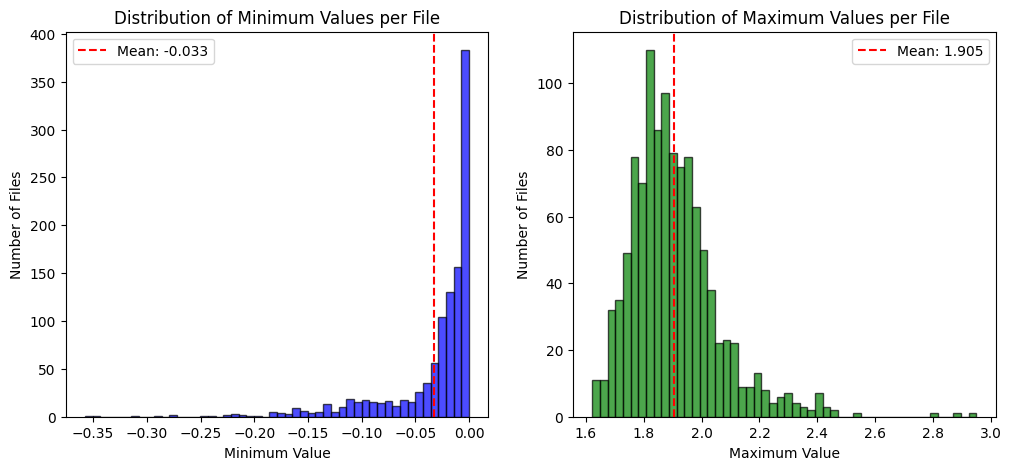

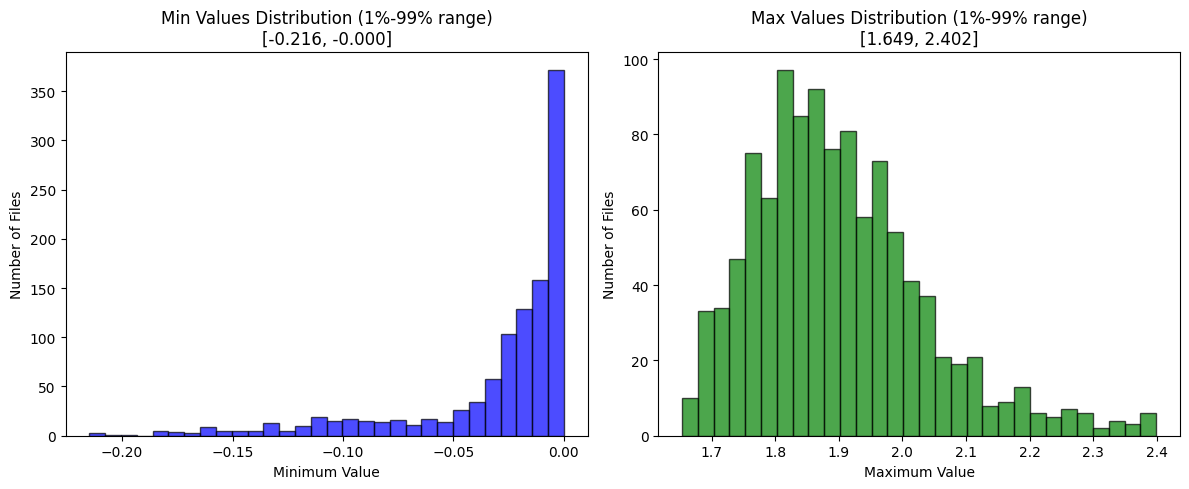


SPECIFIC OUTLIER DETECTION:

Files with MAX intensity > 2.6 (3 files):
  /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test/smci/023_S_2068_2017-11-08_15_50_08.0.nii
    -> Max: 2.882199, Min: -0.017055
  /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/test/smci/023_S_2068_2012-10-18_12_32_48.0.nii
    -> Max: 2.950240, Min: -0.033514
  /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train/pmci/022_S_6863_2020-09-03_14_55_43.0.nii
    -> Max: 2.791236, Min: -0.007837

Files with MIN intensity < -0.25 (6 files):
  /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train/pmci/018_S_0057_2008-02-08_13_00_04.0.nii
    -> Min: -0.278249, Max: 2.116001
  /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train/pmci/018_S_0057_2007-01-05_10_55_55.0.nii
    -> Min: -0.292687, Max: 1.963664
  /home/diogommiranda/tese/datasets/mni_reg_CV/smci_pmci/train/pmci/018_S_0057_2007-10-22_10_39_51.0.nii
    -> Min: -0.349631, Max: 2.107497
  /home/diogommiranda/tese/datase

In [8]:
NORMALIZATION = "mni_reg_CV" # Name of the directory with the datasets
DATASET = "smci_pmci" # Choose dataset: "smci_pmci" or "nc_ad"
DATA_DIR = Path("/home/diogommiranda/tese/datasets/") / NORMALIZATION / DATASET

results = analyse_nifti_distribution(DATA_DIR)
    
# Optional: Save results for later use
if results:
        print(f"\nSuggested normalization bounds based on analysis:")
        print(f"Conservative (1%-99%): min={results['min_percentiles'][1]:.6f}, max={results['max_percentiles'][99]:.6f}")
        print(f"Moderate (5%-95%): min={results['min_percentiles'][5]:.6f}, max={results['max_percentiles'][95]:.6f}")
        print(f"Aggressive (10%-90%): min={results['min_percentiles'][10]:.6f}, max={results['max_percentiles'][90]:.6f}")